In [1]:
import matplotlib as mpl
mpl.use('Agg')
from LiteNet import *
from Datasets import *
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)

%matplotlib inline

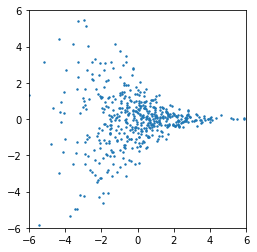

In [2]:
D = 2
p = Funnel(sigma=2, D=D, lim=10)


plot_size=12
ngrid = 100

eval_grid = np.linspace(-plot_size/2,plot_size/2,ngrid) 

if D == 2:
    eval_points = np.array([[xv,yv] 
        for xv in eval_grid
                for yv in eval_grid])
    
rand_train_data = p.sample(500)
plt.scatter(rand_train_data[:,0],rand_train_data[:,1],2)
plt.xlim([-6,6])
plt.ylim([-6,6])
plt.gca().set_aspect("equal")

In [3]:
fn ="funnel_D2_l0_nd5_np100"

def build_model(fn):
    
    param_str = fn.split("_")
    D = int(param_str[1][1:])
    nlayer = int(param_str[2][1:])
    ndim   = (int(param_str[3][2:]),)
    npoint = int(param_str[4][2:])

    points  = tf.Variable(np.zeros((npoint,D)), dtype=FDTYPE, name="points")
    alpha   = tf.Variable(np.zeros(npoint), dtype=FDTYPE, name="alpha")

    
    kernel  = GaussianKernel(1.0)
    if nlayer==0:
        kn = LiteModel(kernel, points=points, alpha=alpha)
    else:
        layer_1 = LinearSoftNetwork((D,), ndim, scope="fc1")
        layers = [LinearSoftNetwork(ndim, ndim, scope="fc"+str(i+2)) for i in range(nlayer-1)]
        network = DeepNetwork([layer_1, ] + layers)
        kernel = CompositeKernel(kernel, network)
        kn = LiteModel(kernel, points=points, alpha=alpha)
    
    return kn

test_data = tf.placeholder(FDTYPE, shape=(None, 2), name="test_data")

kn = build_model(fn)
hv, gv, fv = kn.evaluate_hess_grad_fun(test_data)
ckpt = "ckpts/"+fn+".ckpt"

with tf.Session(config=config) as sess:
    saver = tf.train.Saver()
    saver.restore(sess, ckpt)
        


INFO:tensorflow:Restoring parameters from ckpts/funnel_D2_l0_nd5_np100.ckpt


In [4]:
with tf.Session(config=config) as sess:
    saver = tf.train.Saver()
    saver.restore(sess, ckpt)
    hv_value, gv_value, fv_value = sess.run([hv, gv,fv], feed_dict={test_data:eval_points})
    
    
fv_value = fv_value.reshape(ngrid,ngrid)
gv_value = gv_value.reshape(ngrid,ngrid,2)
logpdf   = fv_value-fv_value.mean()
pdf      = np.exp(logpdf)
pdf /= pdf.sum()

INFO:tensorflow:Restoring parameters from ckpts/funnel_D2_l0_nd5_np100.ckpt


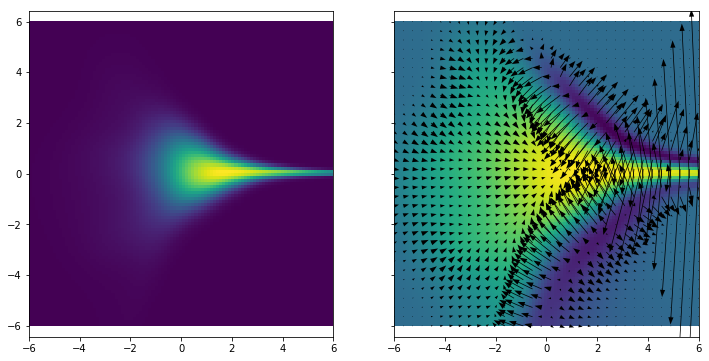

In [21]:
fig, axes = plt.subplots(1,2,figsize=(12,6),sharex=True, sharey=True)

ax = axes[0]
ax.pcolor(eval_grid, eval_grid, pdf.T)

ax.set_aspect("equal")

ax = axes[1]

ax.pcolor(eval_grid, eval_grid, logpdf.T)
g_int = 3
ax.quiver(eval_grid[::g_int], eval_grid[::g_int], gv_value[::g_int,::g_int,0].T, 
           gv_value[::g_int,::g_int,1].T, scale=50, headaxislength=10,headlength=10, headwidth=7)

ax.set_aspect("equal")